
# Bayesian Hierarchical drift-diffusion modelling: A primer
Author: Hu Chuan-Peng (PhD)

Contact: hcp4715 AT hotmail.com


This is the script for illustrating a principled workflow of hierarchical bayesian drift diffusion modelling. We used data from Cavanagh et al.(2011) as an example.This dataset had been used in Wiecki et al (2013).


## About the dataset
### Participants
14 patients with Parkinsons' disease. 12 males, 2 females, age range (46 ~ 77 years).

### Experimental design

Two within-subject design: 
Independent variable: DBS on vs DBS off;
Independent variable: high (win-win; lose-lose) vs. low conflict (win-lose).

Dependent variable:
RT and response.

### Procedure

![Task dynamics](./Cavanagh_2011_procedure.png)

The above figure is from Cavanagh et al (2011)'s figure 1b. The experiment include two session: training and test. During training, participants learned to choose one item in each pair (termed A/B and C/D) that was reinforced more often (A/B, 100%/0%; C/D, 75%/25%). In example below, the butterfly might be A and the piano might be B. During testing, participants had to choose the better stimulus, leading to high-conflict choices for win-win (A/C) and lose-lose (B/D) as well as low-conflict choices (A/D, C/B). For example, if the cake was C in training, this would reflect a high-conflict win-win cue.

Only the testing data are available and used here in this primer.

**Reference of the data**

Cavanagh, J. F., Wiecki, T. V., Cohen, M. X., Figueroa, C. M., Samanta, J., Sherman, S. J., & Frank, M. J. (2011). Subthalamic nucleus stimulation reverses mediofrontal influence over decision threshold. Nature Neuroscience, 14(11), 1462–1467. https://doi.org/10.1038/nn.2925

Wiecki, T. V., Sofer, I., & Frank, M. J. (2013). HDDM: Hierarchical Bayesian estimation of the Drift-Diffusion Model in Python. Frontiers in Neuroinformatics, 7. https://doi.org/10.3389/fninf.2013.00014

In [1]:
%matplotlib inline

# Preparation
import os, hddm, time, csv
import glob
import kabuki 
import datetime
from datetime import date

import pymc as pm
import hddm
import kabuki
print("The current HDDM version is: ", hddm.__version__)

import arviz as az
import numpy as np
import pandas as pd
import feather
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# import sparse # test whether package `sparse` is installed; doesn't matter if not installed.

from p_tqdm import p_map
from functools import partial

# set the color of plots
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmykw')

/opt/conda/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


The current HDDM version is:  0.8.0


## Loading data and explore the data

The data is from `HDDM` package itself, but it was hidden in the `examples` folder, uncomment the following code to find it out:

In [2]:
# # find the directory of "cavanagh_theta_nn.csv"
# print(hddm.__file__)
# !head /opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv

In [3]:
data = hddm.load_csv('/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv')
data.tail()

,subj_idx,stim,rt,response,theta,dbs,conf
3983,13,LL,1.450,0.0,-1.237166,0,HC
3984,13,WL,0.711,1.0,-0.377450,0,LC
3985,13,WL,0.784,1.0,-0.694194,0,LC
3986,13,LL,2.350,0.0,-0.546536,0,HC
3987,13,WW,1.250,1.0,0.752388,0,HC


### Check the number of trials for each condition

Way 1: grouped by `stim`

In [4]:
data.groupby(['subj_idx']).size()

subj_idx
0     298
1     298
2     293
3     255
4     283
5     303
6     299
7     294
8     293
9     217
10    309
11    305
12    267
13    274
dtype: int64

In [5]:
data.groupby(['subj_idx', 'stim', 'dbs']).size()

subj_idx  stim  dbs
0         LL    0      36
                1      37
          WL    0      74
                1      77
          WW    0      38
                       ..
13        LL    1      39
          WL    0      62
                1      73
          WW    0      32
                1      39
Length: 84, dtype: int64

Way 2: grouped by `conf`

In [6]:
data.groupby(['subj_idx', 'conf', 'dbs']).size()

subj_idx  conf  dbs
0         HC    0      74
                1      73
          LC    0      74
                1      77
1         HC    0      70
                1      75
          LC    0      77
                1      76
2         HC    0      77
                1      69
          LC    0      78
                1      69
3         HC    0      68
                1      58
          LC    0      71
                1      58
4         HC    0      73
                1      66
          LC    0      75
                1      69
5         HC    0      77
                1      71
          LC    0      77
                1      78
6         HC    0      75
                1      70
          LC    0      78
                1      76
7         HC    0      75
                1      77
          LC    0      69
                1      73
8         HC    0      73
                1      72
          LC    0      73
                1      75
9         HC    0      57
                1 

### Visualize the raw data

Way 1: Original way

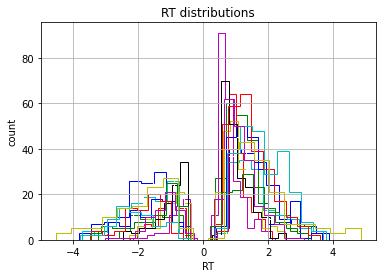

In [7]:
data = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# plt.savefig('hddm_demo_fig_00.pdf')

Way 2: Interactive with plotly

### Visualize the summary results
Here we can reproduce part of Figure 3 in Cavanagh et al. (2011).

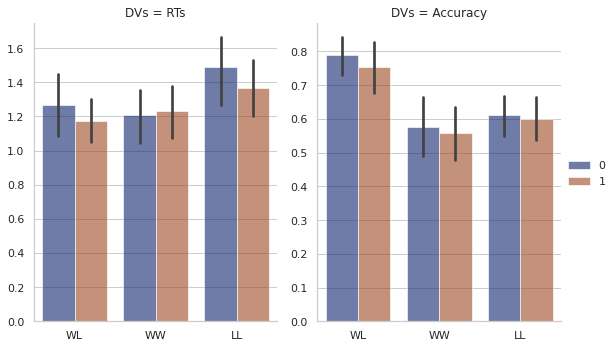

In [8]:
# get the median of accurate RTs
data_rt_sum = data[data['response'] ==1].groupby(['subj_idx','dbs', 'stim'])['rt'].median().reset_index()

# get the mean accuracy (this approach is not optimal)
data_acc_sum = data.groupby(['subj_idx','dbs', 'stim'])['response'].mean().reset_index()

data_rt_sum['DVs'] = 'RTs'
data_rt_sum.rename(columns={'rt':'value'}, inplace=True)
data_acc_sum['DVs'] = 'Accuracy'
data_acc_sum.rename(columns={'response':'value'}, inplace=True)

data_sum = pd.concat([data_rt_sum, data_acc_sum]).reset_index(drop=True)  # concat two dataframes

# # categorize the cond and order the data
from pandas.api.types import CategoricalDtype

stim_type = CategoricalDtype(categories=['WL', 'WW', 'LL'],
                           ordered=True)
data_rt_sum['stim'] = data_rt_sum['stim'].astype(stim_type)
data_acc_sum['stim'] = data_acc_sum['stim'].astype(stim_type)
data_sum['stim'] = data_sum['stim'].astype(stim_type)

### MUST use map_dataframe()
sns.set_theme(style="whitegrid")

g = sns.FacetGrid(data=data_sum, col="DVs", height=5, aspect=.8, sharex=True, sharey=False)
g.map_dataframe(sns.barplot, x='stim', y="value", hue = 'dbs', 
                #order=['valid_high', 'invalid_high', 'valid_low', 'invalid_low'],
                #ci = 'sd', # not used, boostrap confidence interval will be used?
                palette="dark", alpha=.6,)
g.add_legend()

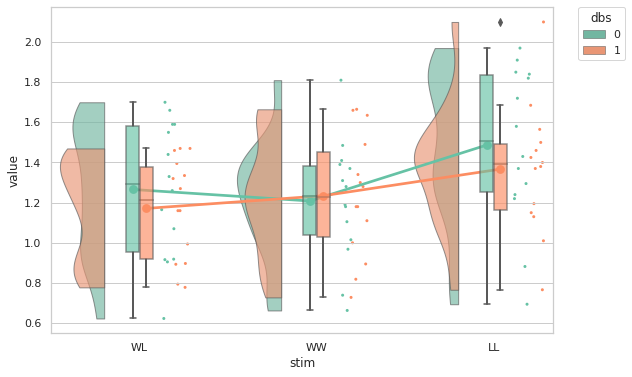

In [9]:
# plot raincloud of RT
import ptitprince as pt

dx = "stim"; dy = "value"; dhue = "dbs"; ort = "v"; pal = "Set2"; sigma = .4

f, ax = plt.subplots(figsize=(9, 6))

ax = pt.RainCloud(x=dx, y=dy, hue=dhue, data=data_rt_sum, palette=pal, 
                  bw=sigma, width_viol=.5,
                  ax=ax, orient=ort, alpha=.65, dodge=True, pointplot=True, move=.2)

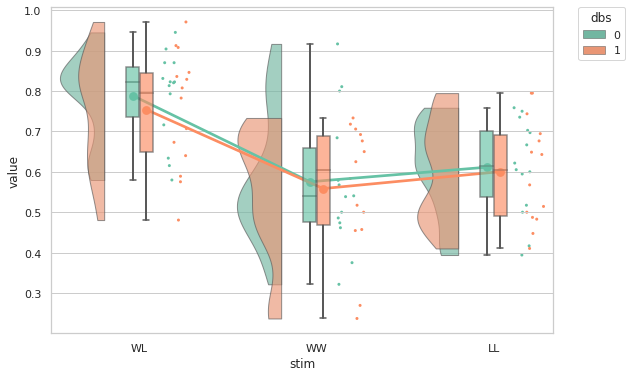

In [10]:
f, ax = plt.subplots(figsize=(9, 6))

ax = pt.RainCloud(x=dx, y=dy, hue=dhue, data=data_acc_sum, palette=pal, 
                  bw=sigma, width_viol=.5,
                  ax=ax, orient=ort, alpha=.65, dodge=True, pointplot=True, move=.2)

In [11]:
# fig, (ax1, ax2) = plt.subplots(nrows=1, 
#                                ncols=2, 
#                                figsize=(12, 6),
#                                sharex=True,
#                                sharey=False)

# ax1 = pt.RainCloud(x=dx, y=dy, hue=dhue, data=data_rt_sum, palette=pal, 
#                   bw=sigma, width_viol=.5,
#                   ax=ax, orient=ort, alpha=.65, dodge=True, pointplot=True, move=.2)

# ax2 = pt.RainCloud(x=dx, y=dy, hue=dhue, data=data_acc_sum, palette=pal, 
#                   bw=sigma, width_viol=.5,
#                   ax=ax, orient=ort, alpha=.65, dodge=True, pointplot=True, move=.2)

# plt.show()

## Prior predictive check

See `prior_pred_check.ipynb`

## Model specification

Model specification is for demonstration purpose.

Here we used models that already showed in previous tutorial, but with more details.

### M0: Baseline model: simplified model

In this model, we only fit a basic hierarchical DDM model, we assume that all the parameters are not varied across any condition.

`m0_0 = HDDM(data)`

$$x_{ij} \sim wfpt(a_j, v_j, t_j, z_j, sv, st, sz)$$
$$v_j \sim N(\mu_v, \sigma_v^2)$$
$$a_j \sim G(\mu_a, \sigma_a^2)$$
$$t_j \sim N(\mu_t, \sigma_t^2)$$
$$z = 0.5 $$
$$sv = 0 $$
$$st = 0 $$
$$sz = 0 $$

$$\mu_a \sim G(1.5, 0.75)$$
$$\sigma_a \sim HN(0.1)$$

$$\mu_v \sim N(\mu = 2, \sigma = 3)$$
$$\sigma_v \sim HN(2)$$

$$\mu_t \sim G(0.4, 0.2)$$
$$\sigma_t \sim HN(1)$$

### M1: Baseline model: full model

`m1 = HDDM(data, include=['z', 'sv', 'sz', 'st'])`

$$x_{ij} \sim wfpt(a_j, v_j, t_j, z_j, sv, st, sz)$$
$$v_j \sim N(\mu_v, \sigma_v^2)$$
$$a_j \sim G(\mu_a, \sigma_a^2)$$
$$t_j \sim N(\mu_t, \sigma_t^2)$$
$$z_j \sim invlogit(N(\mu_z, \sigma_z^2))$$
$$sv \sim HN(2)$$
$$st \sim HN(0.3)$$
$$sz \sim B(1, 3)$$

$$\mu_a \sim G(1.5, 0.75)$$
$$\sigma_a \sim HN(0.1)$$

$$\mu_v \sim N(\mu = 2, \sigma = 3)$$
$$\sigma_v \sim HN(2)$$

$$\mu_z \sim N(0.5, 0.5)$$
$$\sigma_z \sim HN(0.05)$$

$$\mu_t \sim G(0.4, 0.2)$$
$$\sigma_t \sim HN(1)$$

A graphical representation of this model is simpler than the graph appeared in [Wiecki et al, 2013](https://github.com/hddm-devs/hddm/blob/master/docs/paper/graphical_hddm.svg)):

![Graph_m0](./model_graphs/model_graph_basic.svg)


### M2: Depends_on conflict level, full model
In this model, we will use different `v` for different conflict levels, but keep all the other variables' at group level. By doing so, we added one additional level to the model ---- conditions. And this level has two levels: high vs. low. However, for the prior distribution, $v_{j, p}$ share the same priors.

`m2 = HDDM(data, depends_on={'v': 'conf'}, include = ['z', 'sv', 'sz', 'st'])`

$$x_{i, k, j} \sim wfpt(a_j, v_{k, j}, t_j, z_j, sv, st, sz)$$

$$v_{k, j} \sim N(\mu_v, \sigma_v^2)$$
$$a_j \sim G(\mu_a, \sigma_a^2)$$
$$t_j \sim N(\mu_t, \sigma_t^2)$$
$$z_j \sim invlogit(N(\mu_z, \sigma_z^2))$$
$$sv \sim HN(2)$$
$$st \sim HN(0.3)$$
$$sz \sim B(1, 3)$$

$$\mu_a \sim G(1.5, 0.75)$$
$$\sigma_a \sim HN(0.1)$$

$$\mu_v \sim N(\mu = 2, \sigma = 3)$$
$$\sigma_v \sim HN(2)$$

$$\mu_z \sim N(0.5, 0.5)$$
$$\sigma_z \sim HN(0.05)$$

$$\mu_t \sim G(0.4, 0.2)$$
$$\sigma_t \sim HN(1)$$

[Insert graph of m1 here]

### M3: Regressed on conflict level (varying intercept)
In regression models, HDDM can be viewed as a hierarchical generalized linear model. Thus, experiences with generalized hierarchical linear model can be useful.

In previous tutorial, Wiecki et al (2011) demonstrated how to use regression model using `dummy coding` or `treatment coding`. There are also other coding schema available in `patsy`


`m3 = HDDMRegressor(data, "v ~ C(conf, Treatment('LC'))", group_only_regressors=True, include = ['z', 'sv', 'sz', 'st'])`

$$x_{i, k, j} \sim wfpt(a_j, v_{k, j}, t_j, z_j, sv, st, sz)$$

$$v_{k, j} = v_{j_{intercept}} + v_{k_{beta}} * Treatment_k$$

$$v_{j_{intercept}} \sim N(\mu_v, \sigma_v^2)$$
$$v_{k_{beta}} \sim N()$$

$$a_j \sim G(\mu_a, \sigma_a^2)$$
$$t_j \sim N(\mu_t, \sigma_t^2)$$
$$z_j \sim invlogit(N(\mu_z, \sigma_z^2))$$
$$sv \sim HN(2)$$
$$st \sim HN(0.3)$$
$$sz \sim B(1, 3)$$

$$ \alpha_v \sim N(\mu_v, \sigma_v^2)$$
$$ \beta_v \sim N()$$

$$\mu_a \sim G(1.5, 0.75)$$
$$\sigma_a \sim HN(0.1)$$

$$\mu_v \sim N(\mu = 2, \sigma = 3)$$
$$\sigma_v \sim HN(2)$$

$$\mu_z \sim N(0.5, 0.5)$$
$$\sigma_z \sim HN(0.05)$$

$$\mu_t \sim G(0.4, 0.2)$$
$$\sigma_t \sim HN(1)$$


* Contrast vs. variable. In Statistical rethings (page 157, 159), Richard distinguished `indicator variable` and `index variable` and recommended `index variable`. What is the relationship between these two and different contrast (design matrix)?

Now we need to have a bit tour on `patsy`. `patsy` used the grammar that may familiar to those who use `lme4` or related packages (e.g., `brms`).

Very briefly, the grammar of `patsy` is like this:

$$ y \sim a + b*x$$

The left hand side of $\sim$ is the variable need to be predicted, which is usually the outcome (i.e., parameters of DDM in HDDM). the right hand side of the $\sim$ is the predictors. please see the [document of `patsy`](https://patsy.readthedocs.io/en/latest/formulas.html) for more, or see https://arxiv.org/abs/1911.08628 for a more general explanation for MLM.

In `patsy`, the function`dmatrices` can give the design matrix with both the dependent variable on the lefthand side of the formual and the right hand side of the formula, which two parts are delimiited by `~` .

If we are only interested in the right hand side of the formula, which is we usually do, we need `dmatrix`.

As mentioned in `patsy` API, `patsy` has implemented several widely-used way to handle categorical data. 

The most-widely used one is "treatment contrast". 

The `reduced rank` and `full rank` are not familiar to readers from psychology. `redcued rank` is the design matrix with `intercept`, i.e., one level of the condition is selected as a reference. This `reduced rank` is the traditional meaning of `dummy coding` in psychology. `full rank` is the design without a reference, the each column of the resulting matrix represents the mean of the corresponding level. This way of coding is the call `cell mean` . 

In [12]:
from patsy import dmatrix, demo_data
demo = demo_data("a", "b", "x1", "x2", "y", "z column")

In [13]:
dmatrix("x1 + x2", demo)

DesignMatrix with shape (8, 3)
  Intercept        x1        x2
          1   1.76405  -0.10322
          1   0.40016   0.41060
          1   0.97874   0.14404
          1   2.24089   1.45427
          1   1.86756   0.76104
          1  -0.97728   0.12168
          1   0.95009   0.44386
          1  -0.15136   0.33367
  Terms:
    'Intercept' (column 0)
    'x1' (column 1)
    'x2' (column 2)

In [14]:
# show first 20 row of design matrix
dmatrix("C(conf, Treatment('LC'))", data.head(20))

# or using DataFrame:
#pd.DataFrame(dmatrix("C(conf, Treatment('LC'))", data))

DesignMatrix with shape (20, 2)
  Intercept  C(conf, Treatment('LC'))[T.HC]
          1                               1
          1                               0
          1                               1
          1                               0
          1                               1
          1                               0
          1                               1
          1                               0
          1                               1
          1                               0
          1                               1
          1                               0
          1                               1
          1                               1
          1                               0
          1                               0
          1                               1
          1                               0
          1                               0
          1                               0
  Terms:
    'Intercept' (column 0)
    "C(c

### M4: Regressed on conflict level (varying intercept and varying slope)

```
m3 = hddm.HDDMRegressor(data, "v ~ C(conf, Treatment('LC'))", group_only_regressors=False)
```

### M5: Using theta as an additional predictor of `a`
```
m4 = hddm.HDDMRegressor(data[data.dbs == 0],
                        "a ~ theta:C(conf, Treatment('LC'))",
                        depends_on={'v': 'conf'})
```

### M6: Regression for both parameters
```
m6 = hddm.HDDMRegressor(data[data.dbs == 0],
                        "a ~ theta:C(conf, Treatment('LC')),
                         v ~ C(conf, Treatment('LC'))")
```

Two issues that persisted in the users' forum:
* Should we use `HDDMRegressor` whenever the design is within-subject?
* Do we need to start from the `full model` as suggested by some articles on linear mixed model?

### M7: Regression for three parameters

In the tutorial, Cavanagh modelled dbs on and off separately, can we model them in one model?

```
m7 = hddm.HDDMRegressor(data[data.dbs == 0],
     ["a ~ theta:C(conf, Treatment('LC')):C(dbs, Treatment('0')),
     v ~ C(conf, Treatment('LC'))"])
```

Two issues that persisted in the users' forum:
* Should we use `HDDMRegressor` whenever the design is within-subject?
* Do we need to start from the `full model` as suggested by some articles on linear mixed model?

In [15]:
pd.DataFrame(dmatrix("theta:C(conf, Treatment('LC')):C(dbs, Treatment('0'))", data)).head()

,0,1,2,3,4
0,1.0,0.0,0.0,0.656275,0.000000
1,1.0,-0.0,-0.0,-0.000000,-0.327889
2,1.0,-0.0,-0.0,-0.480285,-0.000000
3,1.0,0.0,0.0,0.000000,1.927427
4,1.0,-0.0,-0.0,-0.213236,-0.000000


In [16]:
pd.DataFrame(dmatrix("0 + theta:C(conf, Treatment('LC')):C(dbs, Treatment('0'))", data))

,0,1,2,3
0,0.000000,0.000000,0.656275,0.000000
1,-0.000000,-0.000000,-0.000000,-0.327889
2,-0.000000,-0.000000,-0.480285,-0.000000
3,0.000000,0.000000,0.000000,1.927427
4,-0.000000,-0.000000,-0.213236,-0.000000
...,...,...,...,...
3983,-1.237166,-0.000000,-0.000000,-0.000000
3984,-0.000000,-0.377450,-0.000000,-0.000000
3985,-0.000000,-0.694194,-0.000000,-0.000000
3986,-0.546536,-0.000000,-0.000000,-0.000000


## Parameter recovery

This will be done in a new notebook.


## Fitting hierarchical models and convert

### Model specification

We will only use 2000 samples and burn in 500. Also, we will use 4 chains for each model.

## Model estimation with data
We used parallel processing by `p_tqdm`.

In [17]:
%%time

# define a function to run model in parallel

# M0_0: base model: simplified
def run_m0(id, df=None, samples=None, burn=None, save_name="ms0"): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df)
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M1: base model: full model
def run_m1(id, df=None, samples=None, burn=None, save_name="ms1"): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df, include=['z', 'sv', 'sz', 'st'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m


# M2: treat within-subj as between-subj: full model
def run_m2(id, df=None, samples=None, burn=None, save_name="ms2"): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df, include=['z', 'sv', 'st', 'sz'], 
                  depends_on={'v': 'conf'})
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m


# M3: regression model (varying intercept)
def run_m3(id, df=None, samples=None, burn=None, save_name="ms3"): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id   
    m = hddm.HDDMRegressor(data,  
                           "v ~ C(conf, Treatment('LC'))", 
                           group_only_regressors=True,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M4: regression model (varying intercept and slope)
def run_m4(id, df=None, samples=None, burn=None, save_name="ms4"): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id   
    m = hddm.HDDMRegressor(data,
                           "v ~ C(conf, Treatment('LC'))", 
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M5: regression model + theta as an additional predictor of `a`
def run_m5(id, df=None, samples=None, burn=None, save_name="ms5"): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    m = hddm.HDDMRegressor(data,
                           "a ~ theta:C(conf, Treatment('LC'))",
                           depends_on={'v': 'conf'},
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M6: Regression for both parameters
def run_m6(id, df=None, samples=None, burn=None, save_name="ms6"): 
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    a_reg = {'model': "a ~ theta:C(conf, Treatment('LC'))", 'link_func': lambda x: x}
    v_reg = {'model': "v ~ C(conf, Treatment('LC'))", 'link_func': lambda x: x}
    reg_descr = [a_reg, v_reg]
    
    m = hddm.HDDMRegressor(data,
                           reg_descr,
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M7: Regression for both parameters
def run_m7(id, df=None, samples=None, burn=None, save_name="ms7"): 
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    a_reg = {'model': "a ~ theta:C(conf, Treatment('LC')):C(dbs, Treatment('0'))", 'link_func': lambda x: x}
    v_reg = {'model': "v ~ C(conf, Treatment('LC'))", 'link_func': lambda x: x}
    reg_descr = [a_reg, v_reg]
    
    m = hddm.HDDMRegressor(data,
                           reg_descr,
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.63 µs


Here we define a function to run the model, get posterior, generate posterior predictive, and calculate the point-wise log likelihood. The steps inside can be executed separately too.

In [18]:
samples = 2000
burn = 500
chains = 4
test_mode = False

In [19]:
%%time

## total time: 5h 19s when test_mode is False

## Step 1: run models in parallel
file_path = "/home/jovyan/hddm/temp/"

if test_mode:
    model_func = [run_m2, run_m5, run_m7]
    
    m_keys = ["ms2",
              "ms5",
              "ms7"]
    
    models = {"ms2": [], 
              "ms5": [], 
              "ms7": []}

else: 
    model_func = [run_m0, run_m1, run_m2, run_m3, 
                  run_m4, run_m5, run_m6, run_m7]

    # models = [[]] * len(model_func) hcp, using list in list is very tricky here, when loading 
    # models by for loop, it will end up with each list in the list "models" has 32 elements. 

    m_keys = ["ms0", "ms1", "ms2",
              "ms3", "ms4", "ms5",
              "ms6", "ms7"]
        
    models = {"ms0": [], "ms1": [], "ms2": [], 
              "ms3": [], "ms4": [], "ms5": [], 
              "ms6": [], "ms7": []}

for ii in range(len(model_func)):
    #print(model_func[ii])
    #print(model_name[ii])
    file_full_path = file_path + "*" + m_keys[ii] + "_chain_*[!db]" 
    # print(file_full_path)
    file_names = glob.glob(file_full_path, recursive=False)
    print(file_names)
    
    if file_names:
        for jj in file_names:
            print('current loading: ', jj, '\n')
            models[m_keys[ii]].append(hddm.load(jj))
    else:
        print('current estimating:', m_keys[ii])
        models[m_keys[ii]] = p_map(partial(model_func[ii], df=data, samples=samples, 
                                         burn=burn),
                                 range(chains))

['/home/jovyan/hddm/temp/ms0_chain_1', '/home/jovyan/hddm/temp/ms0_chain_2', '/home/jovyan/hddm/temp/ms0_chain_0', '/home/jovyan/hddm/temp/ms0_chain_3']
current loading:  /home/jovyan/hddm/temp/ms0_chain_1 

current loading:  /home/jovyan/hddm/temp/ms0_chain_2 

current loading:  /home/jovyan/hddm/temp/ms0_chain_0 

current loading:  /home/jovyan/hddm/temp/ms0_chain_3 

['/home/jovyan/hddm/temp/ms1_chain_1', '/home/jovyan/hddm/temp/ms1_chain_3', '/home/jovyan/hddm/temp/ms1_chain_2', '/home/jovyan/hddm/temp/ms1_chain_0']
current loading:  /home/jovyan/hddm/temp/ms1_chain_1 

current loading:  /home/jovyan/hddm/temp/ms1_chain_3 

current loading:  /home/jovyan/hddm/temp/ms1_chain_2 

current loading:  /home/jovyan/hddm/temp/ms1_chain_0 

['/home/jovyan/hddm/temp/ms2_chain_2', '/home/jovyan/hddm/temp/ms2_chain_3', '/home/jovyan/hddm/temp/ms2_chain_1', '/home/jovyan/hddm/temp/ms2_chain_0']
current loading:  /home/jovyan/hddm/temp/ms2_chain_2 

current loading:  /home/jovyan/hddm/temp/ms2_c

In [20]:
%%time

for key, model in models.items():
#     print(len(models[key]))
    print(key + "[0]'s DIC: ", model[0].dic)

ms0[0]'s DIC:  10972.56481117915
ms1[0]'s DIC:  10838.802483238465
ms2[0]'s DIC:  10655.322158367066
ms3[0]'s DIC:  10661.443058395987
ms4[0]'s DIC:  10656.226770282521
ms5[0]'s DIC:  10658.719752245677
ms6[0]'s DIC:  10658.691936194937
ms7[0]'s DIC:  10662.063874857773
CPU times: user 194 ms, sys: 72 µs, total: 195 ms
Wall time: 192 ms


Get the posterior traces (necessary?)

In [21]:
%%time

## step 2: Get posterior trace

if test_mode:
    df_traces = {"ms2": [], 
                 "ms5": [],
                 "ms7": []}
else:
    df_traces = {"ms0": [], "ms1": [], "ms2": [], 
                 "ms3": [], "ms4": [], "ms5": [],
                 "ms6": [], "ms7": []}

for key, model in models.items():
#    ms = models[m_keys[ii]]
    print(key)
#     print(df_traces[m_keys[ii]])
    trace_tmp = []
    for jj in range(len(model)):
        trace_tmp = model[jj].get_traces()
        trace_tmp['chain'] = jj
        trace_tmp['draw'] = np.arange(len(trace_tmp), dtype=int)
        df_traces[key].append(trace_tmp)
    df_traces[key] = pd.concat(df_traces[key])

ms0
ms1
ms2
ms3
ms4
ms5
ms6
ms7
CPU times: user 125 ms, sys: 8.05 ms, total: 133 ms
Wall time: 131 ms


In [22]:
from p_tqdm import p_map
from functools import partial

# NOTE: I hacked the `post_pred_gen`, 
# more detals: https://groups.google.com/g/hddm-users/c/Is6AM7eN0fo
from post_pred_gen_redifined import _parents_to_random_posterior_sample
from post_pred_gen_redifined import _post_pred_generate
from post_pred_gen_redifined import post_pred_gen

from pointwise_loglik_gen import _pointwise_like_generate
from pointwise_loglik_gen import pointwise_like_gen

## PPC

The original PPC function was revise so that (1) the default number of samples of the PPC is the same as MCMC in model fitting; (2) every draw in the posterior will be used for PPC, instead of randomly select from all posteriors.

In [23]:
%%time

## total time: 1d 6h 12min 5s when test_mode is False

if test_mode:
    df_ppc   = {"ms2": [], 
                 "ms5": [],
                 "ms7": []}
#     m_keys = ["df_ppc_2", 
#                 "df_ppc_5", 
#                 "df_ppc_7"]    
else:  
    df_ppc = {"ms0": [], "ms1": [], "ms2": [], 
              "ms3": [], "ms4": [], "ms5": [], 
              "ms6": [], "ms7": []}
#     m_keys = ["df_ppc_0", "df_ppc_1", "df_ppc_2", 
#                 "df_ppc_3", "df_ppc_4", "df_ppc_5", 
#                 "df_ppc_6", "df_ppc_7"]

for ii in range(len(m_keys)):
    key = m_keys[ii]
    value = df_ppc[m_keys[ii]]
    
    if not bool(value):
        print("No PPC values, try to get feather file names")
        # read ftr filenames
        ftr_path = file_path + "df_" + key + "_ppc_chain_*ftr" 
        ftr_names = glob.glob(ftr_path, recursive=False)
#         print(ftr_names)
        
        # if there are ftr files
        if ftr_names:
            print("Got feather file names, loading the PPC")
            for ftrname in ftr_names:
#             for f_id in range(len(ftr_names)):
                print("loading \n", ftrname)
                df_tmp = pd.read_feather(ftrname, columns=None, use_threads=True)
                df_tmp = df_tmp.set_index(["node", "draw", 'trial_idx'])
                df_ppc[key].append(df_tmp)     
        else:
            print("No feather files either, run PPC now ...")
#             for ii in range(len(m_keys)):
            ms = models[m_keys[ii]]
            print("Generating PPC ", key, "for", m_keys[ii])
            start_time = time.time()  # the start time of the processing
        #     df_ppc[m_keys[ii]] = p_map(partial(post_pred_gen, samples = 500), ms)
            df_ppc[key] = p_map(partial(post_pred_gen), ms)

            print("Running PPC costs %f seconds" % (time.time() - start_time))
            
            print("Save PPC to feather files")
            for chain in range(len(df_ppc[key])):
                ftrname = file_path + "df_" + key + "_ppc_chain_" + str(chain) + ".ftr"
                print(ftrname)
                df_ppc[key][chain].reset_index().to_feather(ftrname)
    else:
        continue

No PPC values, try to get feather file names
Got feather file names, loading the PPC
loading 
 /home/jovyan/hddm/temp/df_ms0_ppc_chain_2.ftr
loading 
 /home/jovyan/hddm/temp/df_ms0_ppc_chain_3.ftr
loading 
 /home/jovyan/hddm/temp/df_ms0_ppc_chain_0.ftr
loading 
 /home/jovyan/hddm/temp/df_ms0_ppc_chain_1.ftr
No PPC values, try to get feather file names
Got feather file names, loading the PPC
loading 
 /home/jovyan/hddm/temp/df_ms1_ppc_chain_3.ftr
loading 
 /home/jovyan/hddm/temp/df_ms1_ppc_chain_1.ftr
loading 
 /home/jovyan/hddm/temp/df_ms1_ppc_chain_2.ftr
loading 
 /home/jovyan/hddm/temp/df_ms1_ppc_chain_0.ftr
No PPC values, try to get feather file names
Got feather file names, loading the PPC
loading 
 /home/jovyan/hddm/temp/df_ms2_ppc_chain_0.ftr
loading 
 /home/jovyan/hddm/temp/df_ms2_ppc_chain_1.ftr
loading 
 /home/jovyan/hddm/temp/df_ms2_ppc_chain_3.ftr
loading 
 /home/jovyan/hddm/temp/df_ms2_ppc_chain_2.ftr
No PPC values, try to get feather file names
Got feather file names, load

## Point-wise log-likelihood (PLL)

Calculate the pll based on `node`

In [24]:
%%time

## total time: 2h 38min 51s when test_mode is False

if test_mode:
    df_pll = {"ms2": [],
              "ms5": [],
              "ms7": []}  
#     m_keys = ["df_pll_2", 
#                 "df_pll_5", 
#                 "df_pll_7"]
    
else:
    df_pll = {"ms0": [], "ms1": [], "ms2": [], 
              "ms3": [], "ms4": [], "ms5": [], 
              "ms6": [], "ms7": []}  
#     m_keys = ["df_pll_0", "df_pll_1", "df_pll_2",
#                 "df_pll_3", "df_pll_4", "df_pll_5",
#                 "df_pll_6", "df_pll_7"]

for ii in range(len(m_keys)):
    key = m_keys[ii]
    value = df_pll[m_keys[ii]]

    if not bool(value):
        print("\nNo loglik values, try to get feather file names")
        # read ftr filenames
        ftr_path = file_path + "df_" + key + "_pll_chain_*ftr" 
        ftr_names = glob.glob(ftr_path, recursive=False)
        # print(ftr_names)
        
        # if there are ftr files
        if ftr_names:
            print("Got feather file names, loading the loglik files")
            for ftrname in ftr_names:
                print("loading \n", ftrname)
                df_tmp = pd.read_feather(ftrname, columns=None, use_threads=True)
                df_tmp = df_tmp.set_index(["node", "draw", 'trial_idx'])
                df_pll[key].append(df_tmp)
        else:
            print("No feather files either, run loglik now ...")

            ms = models[m_keys[ii]]
            print("Generating loglik ", key, "for", m_keys[ii])
            start_time = time.time()  # the start time of the processing
            # df_pll[m_keys[ii]] = p_map(partial(pointwise_like_gen, samples = 500), ms)
            df_pll[key] = p_map(partial(pointwise_like_gen), ms)

            print("Generating loglik costs %f seconds" % (time.time() - start_time))
            
            print("Save loglik to feather files")
            for chain in range(len(df_pll[key])):
                ftrname = file_path + "df_" + key + "_pll_chain_" + str(chain) + ".ftr"
                print(ftrname)
                df_pll[key][chain].reset_index().to_feather(ftrname)
    else:
        continue


No loglik values, try to get feather file names
Got feather file names, loading the loglik files
loading 
 /home/jovyan/hddm/temp/df_ms0_pll_chain_3.ftr
loading 
 /home/jovyan/hddm/temp/df_ms0_pll_chain_2.ftr
loading 
 /home/jovyan/hddm/temp/df_ms0_pll_chain_1.ftr
loading 
 /home/jovyan/hddm/temp/df_ms0_pll_chain_0.ftr

No loglik values, try to get feather file names
Got feather file names, loading the loglik files
loading 
 /home/jovyan/hddm/temp/df_ms1_pll_chain_3.ftr
loading 
 /home/jovyan/hddm/temp/df_ms1_pll_chain_2.ftr
loading 
 /home/jovyan/hddm/temp/df_ms1_pll_chain_1.ftr
loading 
 /home/jovyan/hddm/temp/df_ms1_pll_chain_0.ftr

No loglik values, try to get feather file names
Got feather file names, loading the loglik files
loading 
 /home/jovyan/hddm/temp/df_ms2_pll_chain_2.ftr
loading 
 /home/jovyan/hddm/temp/df_ms2_pll_chain_0.ftr
loading 
 /home/jovyan/hddm/temp/df_ms2_pll_chain_3.ftr
loading 
 /home/jovyan/hddm/temp/df_ms2_pll_chain_1.ftr

No loglik values, try to get feat

 [----------       28%                  ] 4 of 14 complete in 128.5 sec[----------       28%                  ] 4 of 14 complete in 129.4 sec[----------       28%                  ] 4 of 14 complete in 130.7 sec[----------       28%                  ] 4 of 14 complete in 132.9 sec[-------------    35%                  ] 5 of 14 complete in 261.1 sec[-------------    35%                  ] 5 of 14 complete in 264.2 sec[-------------    35%                  ] 5 of 14 complete in 266.0 sec[-------------    35%                  ] 5 of 14 complete in 266.4 sec[---------------- 42%                  ] 6 of 14 complete in 389.9 sec[---------------- 42%                  ] 6 of 14 complete in 394.6 sec[---------------- 42%                  ] 6 of 14 complete in 395.0 sec[---------------- 42%                  ] 6 of 14 complete in 399.2 sec[-----------------50%                  ] 7 of 14 complete in 502.9 sec[-----------------50%                  ] 7 of 14 complete in 507.0 sec[-----------------5

 [----------       28%                  ] 4 of 14 complete in 129.1 sec[----------       28%                  ] 4 of 14 complete in 129.2 sec[----------       28%                  ] 4 of 14 complete in 129.1 sec[----------       28%                  ] 4 of 14 complete in 129.3 sec[-------------    35%                  ] 5 of 14 complete in 259.4 sec[-------------    35%                  ] 5 of 14 complete in 259.7 sec[-------------    35%                  ] 5 of 14 complete in 259.9 sec[-------------    35%                  ] 5 of 14 complete in 265.0 sec[---------------- 42%                  ] 6 of 14 complete in 387.6 sec[---------------- 42%                  ] 6 of 14 complete in 388.4 sec[---------------- 42%                  ] 6 of 14 complete in 388.8 sec[---------------- 42%                  ] 6 of 14 complete in 398.4 sec[-----------------50%                  ] 7 of 14 complete in 498.4 sec[-----------------50%                  ] 7 of 14 complete in 499.5 sec[-----------------5

 [-----            14%                  ] 4 of 28 complete in 64.4 sec[-----            14%                  ] 4 of 28 complete in 64.4 sec[-----            14%                  ] 4 of 28 complete in 64.6 sec[-----            14%                  ] 4 of 28 complete in 66.2 sec[------           17%                  ] 5 of 28 complete in 129.0 sec[------           17%                  ] 5 of 28 complete in 129.3 sec[------           17%                  ] 5 of 28 complete in 131.8 sec[------           17%                  ] 5 of 28 complete in 132.0 sec[--------         21%                  ] 6 of 28 complete in 194.0 sec[--------         21%                  ] 6 of 28 complete in 194.5 sec[--------         21%                  ] 6 of 28 complete in 197.8 sec[--------         21%                  ] 6 of 28 complete in 200.3 sec[---------        25%                  ] 7 of 28 complete in 251.2 sec[---------        25%                  ] 7 of 28 complete in 253.4 sec[---------        25%  

/home/jovyan/hddm/temp/df_ms5_pll_chain_3.ftr

No loglik values, try to get feather file names
No feather files either, run loglik now ...
Generating loglik  ms6 for ms6


 [----------       28%                  ] 4 of 14 complete in 146.6 sec[----------       28%                  ] 4 of 14 complete in 146.9 sec[----------       28%                  ] 4 of 14 complete in 151.9 sec[----------       28%                  ] 4 of 14 complete in 153.2 sec[-------------    35%                  ] 5 of 14 complete in 295.0 sec[-------------    35%                  ] 5 of 14 complete in 295.5 sec[-------------    35%                  ] 5 of 14 complete in 303.2 sec[-------------    35%                  ] 5 of 14 complete in 304.3 sec[---------------- 42%                  ] 6 of 14 complete in 440.5 sec[---------------- 42%                  ] 6 of 14 complete in 447.4 sec[---------------- 42%                  ] 6 of 14 complete in 449.8 sec[---------------- 42%                  ] 6 of 14 complete in 450.4 sec[-----------------50%                  ] 7 of 14 complete in 570.2 sec[-----------------50%                  ] 7 of 14 complete in 574.3 sec[-----------------5

 [----------       28%                  ] 4 of 14 complete in 143.6 sec[----------       28%                  ] 4 of 14 complete in 143.7 sec[----------       28%                  ] 4 of 14 complete in 147.2 sec[----------       28%                  ] 4 of 14 complete in 149.1 sec[-------------    35%                  ] 5 of 14 complete in 288.7 sec[-------------    35%                  ] 5 of 14 complete in 293.8 sec[-------------    35%                  ] 5 of 14 complete in 294.4 sec[-------------    35%                  ] 5 of 14 complete in 294.5 sec[---------------- 42%                  ] 6 of 14 complete in 432.4 sec[---------------- 42%                  ] 6 of 14 complete in 440.1 sec[---------------- 42%                  ] 6 of 14 complete in 440.7 sec[---------------- 42%                  ] 6 of 14 complete in 446.0 sec[-----------------50%                  ] 7 of 14 complete in 561.6 sec[-----------------50%                  ] 7 of 14 complete in 566.1 sec[-----------------5

## Covert PPC and log-likelihood to InferenceData

In [25]:
%%time

if test_mode:
    InfData = {"ms2": [], 
                 "ms5": [],
                 "ms7": []}   
#     m_keys = ["InfData_2", 
#                 "InfData_5", 
#                 "InfData_7"]
    
else:
    InfData = {"ms0": [], "ms1": [], "ms2": [], 
              "ms3": [], "ms4": [], "ms5": [], 
              "ms6": [], "ms7": []}  
#     m_keys = ["InfData_0", "InfData_1", "InfData_2",
#                 "InfData_3", "InfData_4", "InfData_5",
#                 "InfData_6", "InfData_7"]

for ii in range(len(models)):
    obs_data = models[m_keys[ii]][0].data.copy()
    obs_data.index.names = ['trial_idx']
    if 'conf' in obs_data.columns:
        obs_data.drop(['subj_idx','stim', 'theta','dbs','conf'], axis=1, inplace=True)
    xdata_observed = xr.Dataset.from_dataframe(obs_data)

    df_traces_tmp = df_traces[m_keys[ii]].set_index(["chain", "draw"])
    xdata_posterior = xr.Dataset.from_dataframe(df_traces_tmp)
    
    df_ppc_tmp = pd.concat(df_ppc[m_keys[ii]], names=['chain'], 
                            keys = list(range(len(df_ppc[m_keys[ii]]))))
#     df_ppc_tmp['response'] = df_ppc_tmp['response'].astype('float')
    df_ppc_tmp = df_ppc_tmp.reset_index(level=1, drop=True)
    xdata_post_pred = xr.Dataset.from_dataframe(df_ppc_tmp)
    
    df_pll_tmp = pd.concat(df_pll[m_keys[ii]], names=['chain'], 
                            keys = list(range(len(df_pll[m_keys[ii]]))))
    df_pll_tmp = df_pll_tmp.reset_index(level=1, drop=True)
    xdata_loglik = xr.Dataset.from_dataframe(df_pll_tmp)
    
    InfData[m_keys[ii]] = az.InferenceData(posterior=xdata_posterior, 
                                             observed_data=xdata_observed,
                                             posterior_predictive=xdata_post_pred,
                                             log_likelihood = xdata_loglik)

CPU times: user 46.6 s, sys: 8.29 s, total: 54.9 s
Wall time: 54.9 s


In [26]:
az.compare(InfData)

/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:908: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, ax

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
ms7,0,-6984.524366,1592.664677,0.000000,0.000000,719.386237,0.000000,True,log
ms6,1,-7087.891440,1690.939648,103.367074,0.000000,791.962393,115.360804,True,log
ms3,2,-7177.441842,1762.696341,192.917476,0.208386,825.937374,135.105539,True,log
ms4,3,-7328.071002,1923.727846,343.546636,0.147960,894.070097,177.278121,True,log
ms5,4,-7365.089880,1973.758599,380.565513,0.437777,876.362399,186.825655,True,log
ms2,5,-7447.039691,2047.867328,462.515324,0.000000,916.394979,213.053865,True,log
ms1,6,-7555.644242,2054.629045,571.119876,0.005530,920.595478,252.561152,True,log
ms0,7,-12305.520195,6789.186865,5320.995829,0.200347,1916.902123,1987.635772,True,log


**NOTE: after running all cells above, around 22 GB memory is used (72% of my PC)**

In [27]:
for key, value in InfData.items():
    print("LOO of ", key)
    print(az.loo(value))

LOO of  ms0


/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:908: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa


Computed from 6000 by 3988 log-likelihood matrix

         Estimate       SE
elpd_loo -12305.52  1916.90
p_loo     6789.19        -

There has been a warning during the calculation. Please check the results.
LOO of  ms1


/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Computed from 6000 by 3988 log-likelihood matrix

         Estimate       SE
elpd_loo -7555.64   920.60
p_loo     2054.63        -

There has been a warning during the calculation. Please check the results.
LOO of  ms2


/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Computed from 6000 by 3988 log-likelihood matrix

         Estimate       SE
elpd_loo -7447.04   916.39
p_loo     2047.87        -

There has been a warning during the calculation. Please check the results.
LOO of  ms3


/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Computed from 6000 by 3988 log-likelihood matrix

         Estimate       SE
elpd_loo -7177.44   825.94
p_loo     1762.70        -

There has been a warning during the calculation. Please check the results.
LOO of  ms4


/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Computed from 6000 by 3988 log-likelihood matrix

         Estimate       SE
elpd_loo -7328.07   894.07
p_loo     1923.73        -

There has been a warning during the calculation. Please check the results.
LOO of  ms5


/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Computed from 6000 by 3988 log-likelihood matrix

         Estimate       SE
elpd_loo -7365.09   876.36
p_loo     1973.76        -

There has been a warning during the calculation. Please check the results.
LOO of  ms6


/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Computed from 6000 by 3988 log-likelihood matrix

         Estimate       SE
elpd_loo -7087.89   791.96
p_loo     1690.94        -

There has been a warning during the calculation. Please check the results.
LOO of  ms7


/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Computed from 6000 by 3988 log-likelihood matrix

         Estimate       SE
elpd_loo -6984.52   719.39
p_loo     1592.66        -

There has been a warning during the calculation. Please check the results.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c51523750>,
      dtype=object)

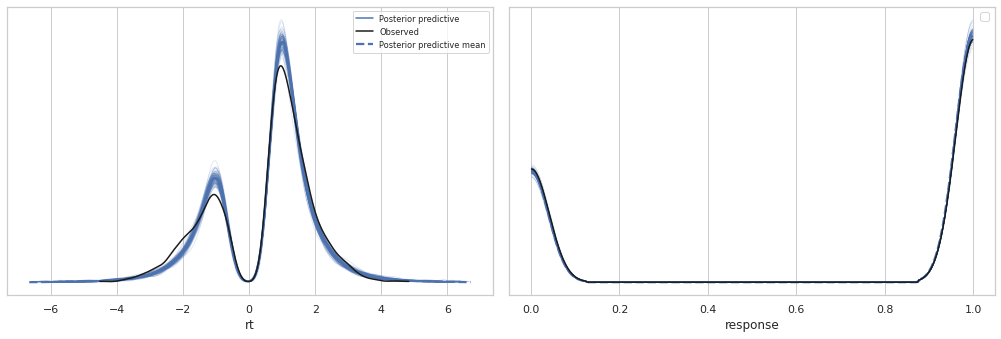

In [28]:
az.plot_ppc(InfData['ms2'], num_pp_samples=100, random_seed=7)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c50945590>,
      dtype=object)

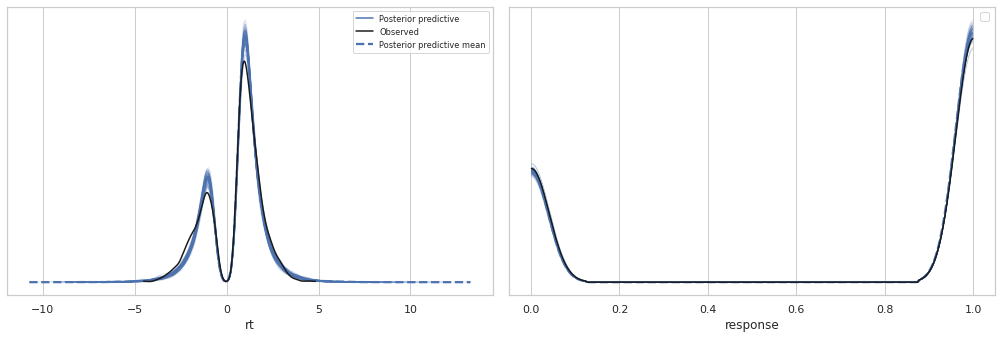

In [29]:
az.plot_ppc(InfData['ms3'], num_pp_samples=100, random_seed=7)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3bdbc3add0>,
      dtype=object)

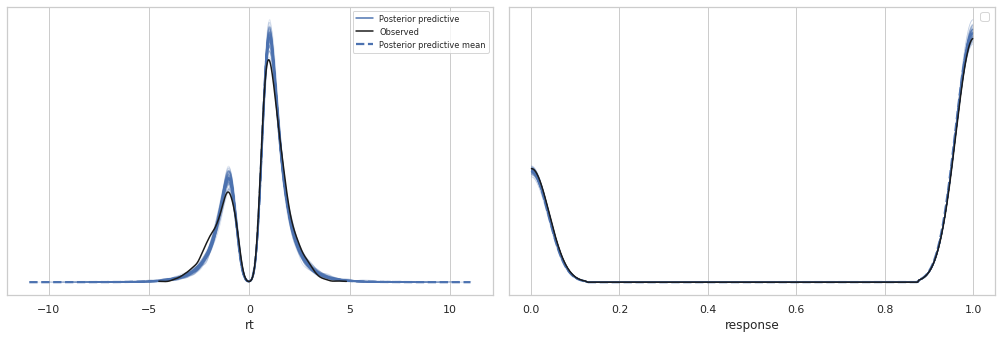

In [31]:
az.plot_ppc(InfData['ms7'], num_pp_samples=100, random_seed=7)